In [1]:
import numpy as np
import pandas as pd

import os, nltk, string, gensim, warnings, pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import preprocessing, ensemble, metrics
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
def csvtotext(df):
  text = df.to_csv(sep=' ', index=False, header=False).lower()
  return(text)

In [3]:
def cleantext(text):
    full_tokens = word_tokenize(text)
    tokens = [word for word in full_tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word)>1]        
    return(full_tokens, tokens)

In [4]:
def word_freq_analyser(tokens):
    freq = nltk.FreqDist(tokens)
    freqdf = pd.DataFrame.from_dict(freq,orient='index')
    freqdf = freqdf.reset_index()
    freqdf = freqdf.rename(columns={'index' : 'word', 0:'count'})
    freqdf = freqdf.sort_values(by = ['count'], ascending = False)
    freqdf = freqdf.reset_index(drop=True)
    freqdf = freqdf.reset_index()
    freqdf = freqdf.rename(columns={'index' : 'sno'})
    freqdf['sno'] = freqdf['sno'] + 1
    freqdf['distinct_word_%'] = freqdf['sno']/len(freqdf['sno']) * 100
    freqdf['cumsum'] = freqdf['count'].cumsum()
    freqdf['corpus_%'] = freqdf['cumsum'] / freqdf['count'].sum() * 100
    
    freqdf['distinct_word_%'] = np.round(freqdf['distinct_word_%'], 0)
    freqdf['corpus_%'] = np.round(freqdf['corpus_%'], 0)
    
    small_freq_df = freqdf.drop_duplicates(subset=['corpus_%'], keep = 'first')
    
    return(freqdf, small_freq_df)    

In [5]:
def plot_reverse_elbow_curve(small_freq_df):
    x = small_freq_df['distinct_word_%']
    y = small_freq_df['corpus_%']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)


    ax.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
    plt.xticks(np.arange(min(x), 100, 2))
    plt.yticks(np.arange(min(y), 100, 10))
    plt.xlabel ('distinct_word_%')
    plt.ylabel ('corpus_%')
    return(plt)

In [6]:
def create_report_df(small_freq_df, freqdf):
    df_report = pd.DataFrame()
    imp_deciles = list(np.arange(75,101,5))
    num_of_words = []
    perc_of_dist_words = []

    for dec in imp_deciles:
        perc_of_dist_words.append(small_freq_df[small_freq_df['corpus_%'] == dec].reset_index()['distinct_word_%'][0])
        num_of_words.append(small_freq_df[small_freq_df['corpus_%'] == dec].reset_index()['sno'][0])

    df_report['num_of_words'] = num_of_words
    df_report['dist_words%'] = perc_of_dist_words
    df_report['corpus%'] = imp_deciles
    report1 = f'1. Most frequent {df_report["num_of_words"][0]} unique words, which are {df_report["dist_words%"][0]}% of the total distinct words, are contributing to the {df_report["corpus%"][0]}% of the total corpus.'
    
    dist_word_count_90 = small_freq_df[small_freq_df['corpus_%'] == 90].reset_index()['sno'][0]
    dist_word_count_100 = freqdf['sno'].iloc[-1]
    dist_word_90_100 = dist_word_count_100 - dist_word_count_90
    dist_word_bottom_perc = np.round((dist_word_90_100 / dist_word_count_100)*100,1)
    report2 = f'2. Least frequent {dist_word_90_100} unique words, which are {dist_word_bottom_perc}% of the total distinct words, are contributing only to the bottom 10% of the total corpus.'

    print("---------------------------------- Analysis Results ----------------------------------")
    print(report1)
    print(report2)
    print("--------------------------------------------")
    print(df_report)
    print("--------------------")
    print('num_of_words : Distinct count of Top-most frequent words')
    print('dist_words%  : num_of_words / total distinct words in corpus')
    print('corpus%      : Total count of num_of_words / Total number of words in corpus')
    print("--------------------------------------------")
    return(df_report)

In [7]:
def dynamic_stop_word_analyzer(tokens):
    freqdf, small_freq_df = word_freq_analyser(tokens)
    plt = plot_reverse_elbow_curve(small_freq_df) 
    df_report = create_report_df(small_freq_df, freqdf)
    return(freqdf, small_freq_df, df_report)

In [8]:
def get_dynamic_stop_words_list(freqdf, corpus_perc_threshold):
    dynamic_stop_words_list = list(freqdf[freqdf['corpus_%'] < corpus_perc_threshold]['word'])    
    return(dynamic_stop_words_list)

In [9]:
#...............................................................................................    
def send_telegram_message(message_text):  
    data = {}
    import requests
    chat_id = "-773311834"
    tester_bot_token = "5237058133:AAH3KdHe4sh95aHrZJXWyTjNxBbUjQAqi4U"
    data['telegram_url'] = "https://api.telegram.org/bot"
    data['url_for_Chat_id'] = f'{tester_bot_token}/getUpdates'   
    
    send_message_url = f'{data["telegram_url"]}{tester_bot_token}/sendMessage?chat_id={chat_id}/&text={message_text}'
    requests.get(send_message_url)
#...............................................................................................  

In [10]:
def create_tokens_list_of_list(tokens):   
        
    sentence = []
    message = []
    for word in tokens:
        if word != '§':
            sentence.append(word)
        if word == '§':
            message.append(sentence)
            sentence = []
    
    joined_message = [' '.join(x) for x in message]    
    return(message, joined_message)

In [11]:
def remove_stop_words(full_tokens, stop_list):            
    
    tokens = [word for word in full_tokens if word == "§" or word.isalpha()]
    tokens = [word for word in tokens if word == "§" or len(word)>1]
#     tokens = [word for word in tokens if word == "§" or word in stop_list]
    return(tokens)

In [12]:
def tfvect(df, train_x, valid_x):
    tf_vect = TfidfVectorizer(max_df = 1.0, min_df = 1)
    tf_vect.fit(df['reduced_text'])

    train_x_tf =  tf_vect.transform(train_x)
    valid_x_tf =  tf_vect.transform(valid_x)
  
#     pd.DataFrame(train_x_tf.A, columns=tf_vect.get_feature_names()).to_csv('tf_vect.csv')
#     pickle.dump(tf_vect.vocabulary_,open("tffeatures.pkl","wb"))
    
    return(train_x_tf,valid_x_tf)

In [13]:
def countvect(df, train_x, valid_x):
    count_vect = CountVectorizer(max_df = 1.0, min_df = 1)
    count_vect.fit(df['reduced_text'])

    train_x_cv =  count_vect.transform(train_x)
    valid_x_cv =  count_vect.transform(valid_x)

    #pd.DataFrame(train_x_cv.A, columns=count_vect.get_feature_names()).to_csv('count_vect.csv')
    
    return(train_x_cv,valid_x_cv,count_vect)

In [14]:
def encodelabel(train_y,valid_y):
    encoder = preprocessing.LabelEncoder()
    train_y_count = encoder.fit_transform(train_y)
    valid_y_count = encoder.fit_transform(valid_y)

    train_y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
    valid_y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))

    print('train_y_map :',train_y_map,)
    print('valid_y_map :',valid_y_map)
    
    return(train_y_count, train_y_map, valid_y_count, valid_y_map)

In [15]:
# source_df = pd.read_csv('data/Corona_NLP_train.csv', encoding = "ISO-8859-1")
# source_df = source_df.rename(columns = {'OriginalTweet' : 'original_text', 'Sentiment': 'label'})

source_df = pd.read_csv('data/spam.csv')
source_df = source_df.rename(columns = {'text' : 'original_text'})

In [16]:
source_df

,label,original_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [17]:
df = source_df.copy()
df.loc[df['label'] == 'Extremely Negative', 'label'] = 'Negative'
df.loc[df['label'] == 'Extremely Positive', 'label'] = 'Positive'

df = df[['original_text', 'label']]
df['original_text'] = df['original_text'] + " § "

text = csvtotext(df['original_text'])
full_tokens, tokens = cleantext(text)

---------------------------------- Analysis Results ----------------------------------
1. Most frequent 553 unique words, which are 8.0% of the total distinct words, are contributing to the 75% of the total corpus.
2. Least frequent 5348 unique words, which are 73.7% of the total distinct words, are contributing only to the bottom 10% of the total corpus.
--------------------------------------------
   num_of_words  dist_words%  corpus%
0           553          8.0       75
1           794         11.0       80
2          1196         16.0       85
3          1913         26.0       90
4          3418         47.0       95
5          6889         95.0      100
--------------------
num_of_words : Distinct count of Top-most frequent words
dist_words%  : num_of_words / total distinct words in corpus
corpus%      : Total count of num_of_words / Total number of words in corpus
--------------------------------------------


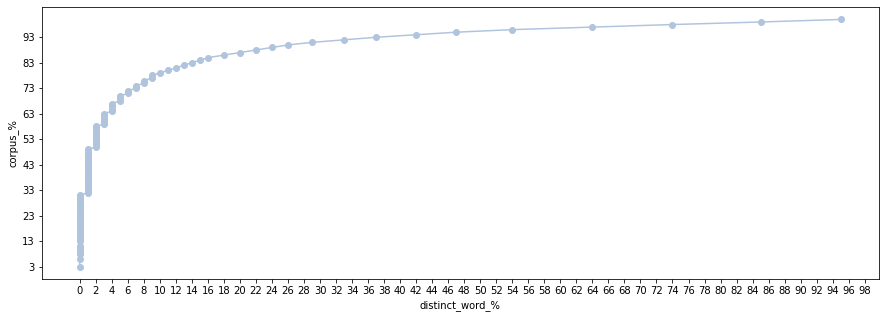

In [18]:
freqdf, small_freq_df, df_report = dynamic_stop_word_analyzer(tokens)

tokens = remove_stop_words(full_tokens, dynamic_stop_words_list)
message, joined_message = create_tokens_list_of_list(tokens)

### Modelling

In [19]:
%%time
nltk_stopwords = stopwords.words('english')

tokens = remove_stop_words(full_tokens, nltk_stopwords)
tokens = [word for word in tokens if word == "§" or word not in nltk_stopwords]
message, joined_message = create_tokens_list_of_list(tokens)

df['reduced_text'] = joined_message

Wall time: 135 ms


In [20]:
train_x, valid_x, train_y, valid_y = train_test_split(df['reduced_text'], df['label'],train_size = 0.8,random_state = 1)

In [21]:
train_x_cv, valid_x_cv, count_vect = countvect(df, train_x, valid_x)
train_y_count, train_y_map, valid_y_count, valid_y_map = encodelabel(train_y,valid_y)

train_y_map : {0: 'ham', 1: 'spam'}
valid_y_map : {0: 'ham', 1: 'spam'}


In [22]:
%%time
clf = ensemble.RandomForestClassifier().fit(train_x_cv, train_y_count)
predictions = clf.predict(valid_x_cv)   
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc

Wall time: 4.04 s


0.9829596412556054

In [23]:
train_x_cv.shape

(4457, 7137)

In [24]:
print(classification_report(predictions, valid_y_count,target_names=list(valid_y_map.values())))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       991
        spam       0.88      0.98      0.93       124

    accuracy                           0.98      1115
   macro avg       0.94      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# --------------------------------------------

In [96]:
corpus_perc_threshold = 80

dynamic_stop_words_list = get_dynamic_stop_words_list(freqdf, corpus_perc_threshold)

In [97]:
df = source_df.copy()
df.loc[df['label'] == 'Extremely Negative', 'label'] = 'Negative'
df.loc[df['label'] == 'Extremely Positive', 'label'] = 'Positive'

df = df[['original_text', 'label']]
df['original_text'] = df['original_text'] + " § "

text = csvtotext(df['original_text'])
full_tokens, tokens = cleantext(text)

In [98]:
%%time
# nltk_stopwords = stopwords.words('english')

tokens = remove_stop_words(full_tokens, nltk_stopwords)
tokens = [word for word in tokens if word == "§" or word not in nltk_stopwords]
tokens = [word for word in tokens if word == "§" or word in dynamic_stop_words_list]


# tokens = remove_stop_words(full_tokens, dynamic_stop_words_list)
message, joined_message = create_tokens_list_of_list(tokens)

df['reduced_text'] = joined_message
# df[-100:].to_csv('data/temp.csv')

Wall time: 352 ms


In [99]:
# send_telegram_message('run complete')

In [100]:
train_x, valid_x, train_y, valid_y = train_test_split(df['reduced_text'], df['label'],train_size = 0.8,random_state = 1)

In [101]:
train_x_cv, valid_x_cv, count_vect = countvect(df, train_x, valid_x)
train_y_count, train_y_map, valid_y_count, valid_y_map = encodelabel(train_y,valid_y)

train_y_map : {0: 'ham', 1: 'spam'}
valid_y_map : {0: 'ham', 1: 'spam'}


In [102]:
%%time
clf = ensemble.RandomForestClassifier().fit(train_x_cv, train_y_count)
predictions = clf.predict(valid_x_cv)   
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc

Wall time: 586 ms


0.9811659192825112

In [103]:
train_x_cv.shape

(4457, 689)

In [104]:
print(classification_report(predictions, valid_y_count,target_names=list(valid_y_map.values())))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       985
        spam       0.89      0.95      0.92       130

    accuracy                           0.98      1115
   macro avg       0.94      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# --------------------------------------------